In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
import pandas as pd

В цьому вікні Ви можете задати функції T(x), b(x), s(x), f(x), константу q, за бажанням: функцію U(x)(точний розв'язок диференціального рівняння) і розбиття ni.

In [29]:
ni = [3, 5, 10, 30, 50, 100, 500]
u = None


# T = lambda x: -2*x - 1
# b = lambda x: 2*x - 3
# s = lambda x: -2
# f = lambda x: x**2 + x
# u = lambda x: (1.0/2)*(3 - 4*x + x**2)
# q = -2


# T = lambda x: 7*x
# b = lambda x: -7
# s = lambda x: 0
# f = lambda x: 14*x**2
# u = lambda x:(1.0/3)*(1 - x**3)
# q = 0


# (Приклад з колоквіуму)
# T = lambda x: 1     
# b = lambda x: 1
# s = lambda x: 1
# f = lambda x: 10
# q = -3

T = lambda x: x 
b = lambda x: 0
s = lambda x: 2
f = lambda x: 14*x**2
q = 0

# T = lambda x: math.e**(x)
# b = lambda x: 3*x**2
# s = lambda x: -10*x
# f = lambda x: math.log(x)
# q = 0

a0 = 0
a1 = 1

In [30]:
class Kurant:
    def __init__(self, xi):
        self.xi = xi
    

    def CountFunction(self, x, i):
        h = self.xi[1] - self.xi[0]
        if i == 0:
            if x >= self.xi[0] and x <= self.xi[1]:
                return (self.xi[1] - x) / h
            return 0

        if i == self.xi.size:
            if x >= self.xi[i - 1] and x <= self.xi[i]:
                return (x - self.xi[i - 1]) / h
            return 0
        
        if x >= self.xi[i - 1] and x <= self.xi[i]:
            return (x - self.xi[i - 1]) / h

        if x >= self.xi[i] and x <= self.xi[i + 1]:
            return (self.xi[i + 1] - x) / h

        return 0  
    

    def plot_Kurant(self, n, a0, a1):
        amount_in_row = 5
        
        rows = (n) // (amount_in_row)
        start = 0
        end = 0
        for row in range(rows + 1):
            end += amount_in_row
            if (end > n+1):
                end = n+1
            _, axes = plt.subplots(1, end - start, figsize=(27, 5))
            plt.title("Базисні функції Куранта")
            for i in range(start, end):
                if(end - start) == 1:
                    axes.plot(self.xi, np.array([self.CountFunction(val, i) for val in self.xi]),  zorder=3, linewidth=2)
                    axes.grid(zorder=0)
                    axes.set_title('Базисна функція для і = ' + str(i))
                    axes.set_xlabel('X')
                    axes.set_ylabel('Phi(x)')
                else:
                    axes[i - start].plot(self.xi, np.array([self.CountFunction(val, i) for val in self.xi]),  zorder=3, linewidth=2)
                    axes[i - start].grid(zorder=0)
                    axes[i - start].set_title('Базисна функція для і = ' + str(i))
                    axes[i - start].set_xlabel('X')
                    axes[i - start].set_ylabel('Phi(x)')
            start += amount_in_row 
            plt.show()
       


In [31]:
class GlobalMatrix:
    def __init__(self, n, xi, T, b, s, f, q):
        self.n = n
      
        self.matrix = np.zeros((n, n))
        self.vector = np.zeros((n))
        self.FillMatrix(xi, T, b, s, f, q)
    

    def FillMatrix(self, xi, T, b, s, f, q):
        h = xi[1] - xi[0]
        xi_m_half = (xi - h/2)
        xi_p_half = (xi + h/2)

        self.matrix[0][0] =  (1 / h) * T(xi_p_half[0]) - (1.0 / 2) * b(xi_p_half[0]) + (h / 3) * s(xi_p_half[0])
        self.vector[0] = (h / 2) * f(xi_p_half[0]) + q

        for i in range(1, self.n):
            self.matrix[i][i] = (1 / h) * T(xi_m_half[i]) + (1 / h) * T(xi_p_half[i]) + \
                                (1.0 / 2) * b(xi_m_half[i]) - (1.0 / 2) * b(xi_p_half[i]) + \
                                (h / 3) * s(xi_m_half[i]) + (h / 3) * s(xi_p_half[i])
            self.matrix[i][i-1] = (-1 / h) * T(xi_p_half[i-1]) - (1.0 / 2) * b(xi_p_half[i-1]) + \
                                    (h / 6) * s(xi_p_half[i-1])
            self.matrix[i-1][i] = (-1 / h) * T(xi_p_half[i-1]) + (1.0 / 2) * b(xi_p_half[i-1]) + \
                                    (h / 6) * s(xi_p_half[i-1])
            self.vector[i] = (h / 2) * f(xi_m_half[i]) + (h / 2) * f(xi_p_half[i])

       

    def ProgonkaMethod(self):
        top = np.zeros((self.n))
        center = np.zeros((self.n))
        bottom = np.zeros((self.n))
        result = np.zeros((self.n))
        vec = self.vector.copy()

        for i in range(self.n -1):
            center[i] = self.matrix[i][i]
            top[i + 1] = self.matrix[i + 1][i]
            bottom[i] = self.matrix[i][i + 1]
        
        center[self.n  - 1] = self.matrix[self.n  - 1][self.n  - 1]
        bottom[0] /= center[0];
        vec[0] /= center[0];
        for i in range(1, self.n ):
            id = 1 / (center[i] - bottom[i - 1] * top[i])
            bottom[i] *= id;
            vec[i] = (vec[i] - vec[i - 1] * top[i]) * id
        
        result[self.n  - 1] = vec[self.n  - 1]
        for i in range(self.n - 2, -1, -1):
            result[i] = vec[i] - bottom[i] * result[i + 1]

        return result


    def __str__(self):
        r = ""
        for i in range(self.n-1):
            for j in range(self.n-1):
                r += str(self.matrix[i][j]) + "*q" + str(j) + " + "
            r = r[:-2] + "= " + str(self.vector[i]) + "\n"
        return r

In [32]:
class MSE:
    def __init__(self, n, phi, qi):
        self.n = n
        self.phi = phi
        self.qi = qi

    def U_h(self, x):
        u = 0
        for i in range(0, self.n):
            u += self.phi.CountFunction(x, i) * self.qi[i]
        return u

    def count_zero_norma(self, a0, a1):
        h = (a1 - a0)/(self.n)
        norma = 0
        for i in range(0, self.n - 1):
            norma += (self.qi[i] ** 2 + self.qi[i] * self.qi[i + 1] + self.qi[i + 1] ** 2)
        norma += (self.qi[self.n-1] ** 2)  
        norma = math.sqrt((h / 3) * norma)
        return norma
    
    def count_first_norma(self, a0, a1):
        h = (a1 - a0)/(self.n)
        norma = 0
        u0 = self.count_zero_norma(a0, a1)
        for i in range(0, self.n - 1):
            norma += (self.qi[i] - self.qi[i + 1]) ** 2
        norma += (self.qi[self.n - 1]) ** 2
        norma = math.sqrt((1.0 / h) * (norma) + u0**2)
        return norma
    

In [33]:
def plot_function(u, a0, a1, title, x_lable, y_lable, n=None):
    
    xdata = np.linspace(a0, a1, 1001)
    _, ax1 = plt.subplots( figsize=(15, 10))
    
    ydata = np.array([u(i) for i in xdata])
    ax1.plot(xdata, ydata,  zorder=3, linewidth=3)
    if (n != None):
        xdata2 = np.linspace(a0, a1, n + 1)
        ydata2 = np.array([u(i) for i in xdata2])
        ax1.plot(xdata2, ydata2, "o", zorder=3, linewidth=3, color="red")

    plt.title(title)
    ax1.grid(zorder=0)
    ax1.set_xlabel(x_lable)
    ax1.set_ylabel(y_lable)


    plt.show()


In [34]:
def build_table(ni, wide=True):
    table = pd.DataFrame(columns=["n", "zero_norma","first_norma"])

    for n in ni:
        xi = np.linspace(a0, a1, n + 1)
        phi = Kurant(xi)
          
        g = GlobalMatrix(n, xi, T, b, s, f, q)
        qi = g.ProgonkaMethod()

        for i, qq in enumerate(qi):
            print("q" + str(i) + " = " + str(qq))

        mse = MSE(n, phi, qi)
        uh = lambda x: mse.U_h(x)

        if (wide):
            print("xi: ", xi)
            phi.plot_Kurant(n, a0, a1)

        plot_function(uh, a0, a1, "Графік апроксимації", 'X', 'Uh(x)', n)
        
        u0 = mse.count_zero_norma(a0, a1)
        u1 = mse.count_first_norma(a0, a1)
        
        data = {"n": n,
                "zero_norma": u0,
                "first_norma": u1,
                }
        table = table.append(data, ignore_index=True)
    table = table.astype({'n':'int'})
    return table
    


q0 = 0.4998516980572443
q1 = 0.7616293440110729
q2 = 0.7338425033367935


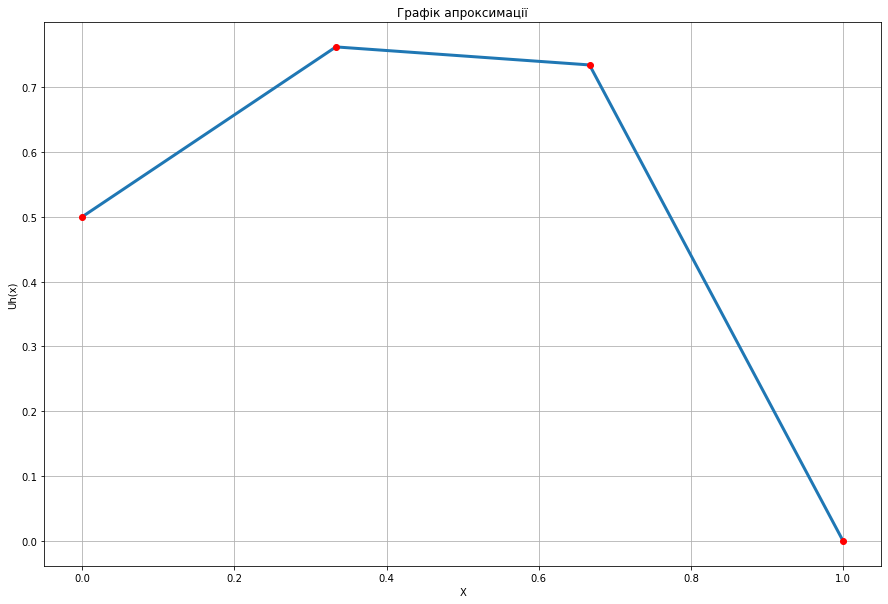

q0 = 0.4436587483561955
q1 = 0.6161166322129011
q2 = 0.7425201688801565
q3 = 0.7434187182397987
q4 = 0.528919870881852


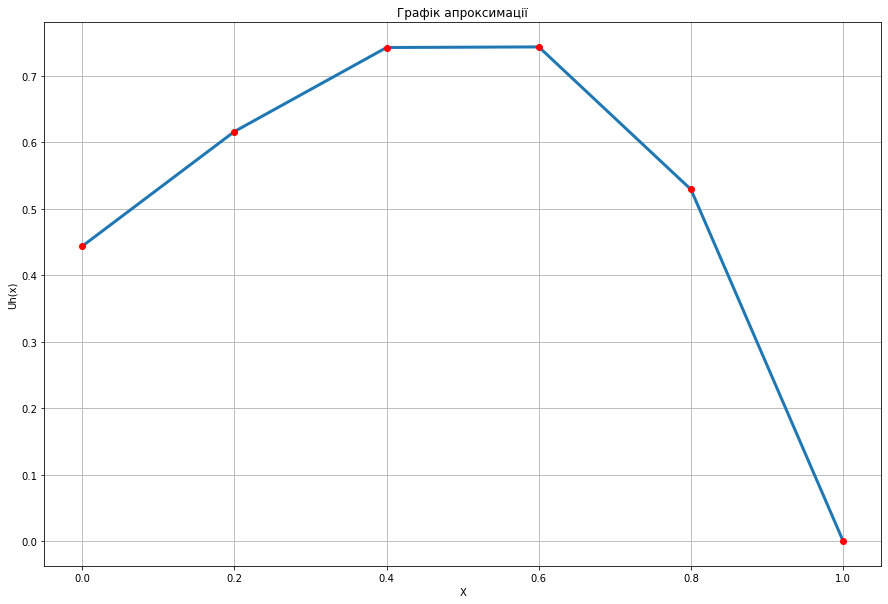

q0 = 0.4219294159524488
q1 = 0.5085928622279735
q2 = 0.5935893490740005
q3 = 0.6681350452316921
q4 = 0.7223676585688009
q5 = 0.745870626766354
q6 = 0.7276975871265383
q7 = 0.6563615408473085
q8 = 0.5198167920388854
q9 = 0.3054383551063914


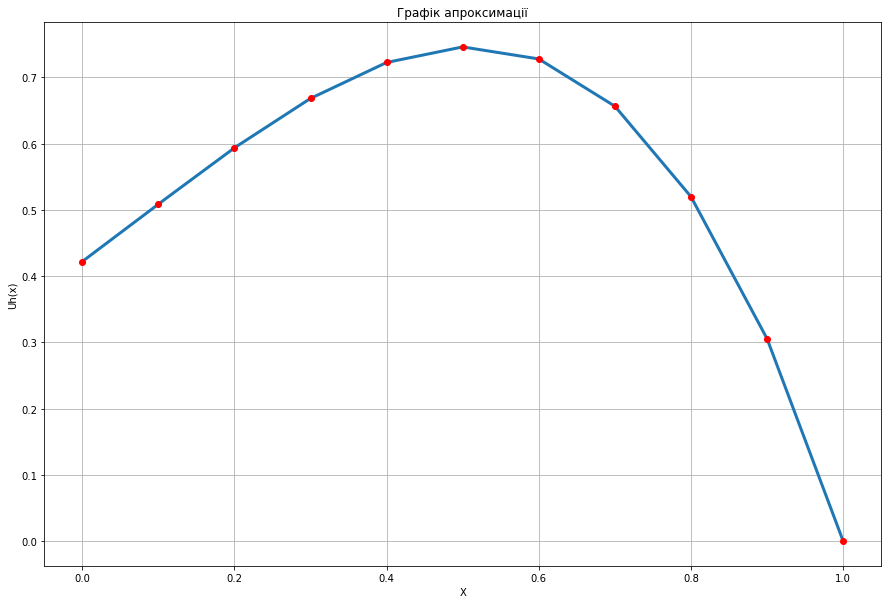

q0 = 0.41604802041093014
q1 = 0.44428235513591785
q2 = 0.47301124711637776
q3 = 0.5019818081643534
q4 = 0.5308659796836719
q5 = 0.5593226440446488
q6 = 0.5870029981595662
q7 = 0.6135517075004223
q8 = 0.6386072314866672
q9 = 0.6618019084792272
q10 = 0.6827619529833541
q11 = 0.7011074152620524
q12 = 0.7164521227565691
q13 = 0.7284036117416252
q14 = 0.7365630532212951
q15 = 0.7405251751095725
q16 = 0.7398781817998912
q17 = 0.7342036717485236
q18 = 0.7230765534390757
q19 = 0.7060649599504323
q20 = 0.682730162265864
q21 = 0.6526264814098607
q22 = 0.6153011994674216
q23 = 0.5702944695201858
q24 = 0.5171392245204616
q25 = 0.455361085115307
q26 = 0.3844782664267272
q27 = 0.304001483789825
q28 = 0.2134338574477464
q29 = 0.11227081620010625


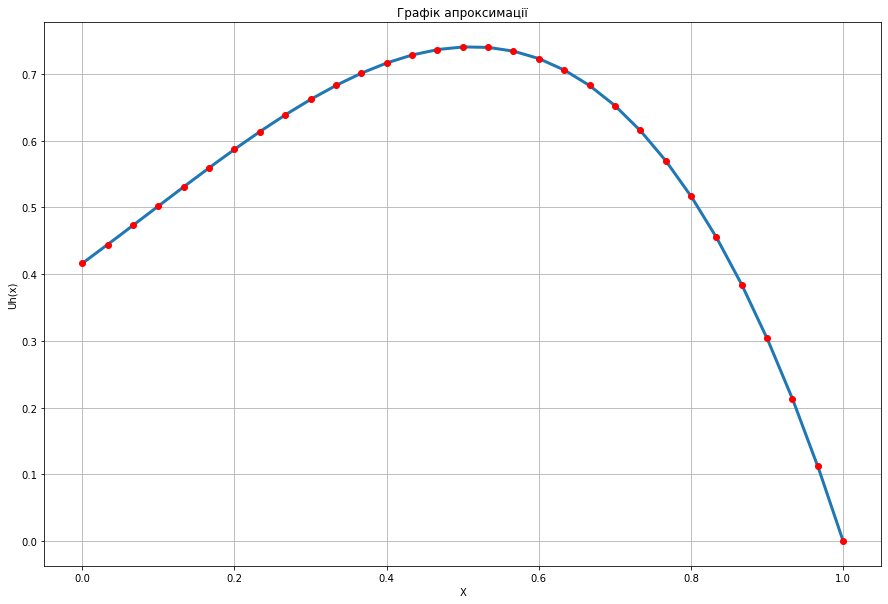

q0 = 0.41562391084685874
q1 = 0.4324451504757854
q2 = 0.4494917693837999
q3 = 0.4667216978642761
q4 = 0.4840669716026041
q5 = 0.5014561782324255
q6 = 0.5188164480599671
q7 = 0.536073902912384
q8 = 0.5531538001043131
q9 = 0.5699805875802582
q10 = 0.5864779266040187
q11 = 0.6025687006379822
q12 = 0.6181750176526494
q13 = 0.6332182090289575
q14 = 0.64761882656521
q15 = 0.6612966383650102
q16 = 0.6741706240289324
q17 = 0.6861589693915554
q18 = 0.6971790609477595
q19 = 0.7071474800570482
q20 = 0.7159799969823252
q21 = 0.7235915647999585
q22 = 0.7298963132057291
q23 = 0.7348075422334233
q24 = 0.7382377158976801
q25 = 0.7400984557692717
q26 = 0.7403005344886348
q27 = 0.7387538692218447
q28 = 0.7353675150620747
q29 = 0.7300496583787525
q30 = 0.7227076101160385
q31 = 0.7132477990418036
q32 = 0.7015757649479639
q33 = 0.6875961518027834
q34 = 0.6712127008555715
q35 = 0.6523282436940604
q36 = 0.6308446952546364
q37 = 0.6066630467855157
q38 = 0.579683358762889
q39 = 0.5498047537600012
q40 = 0.51692

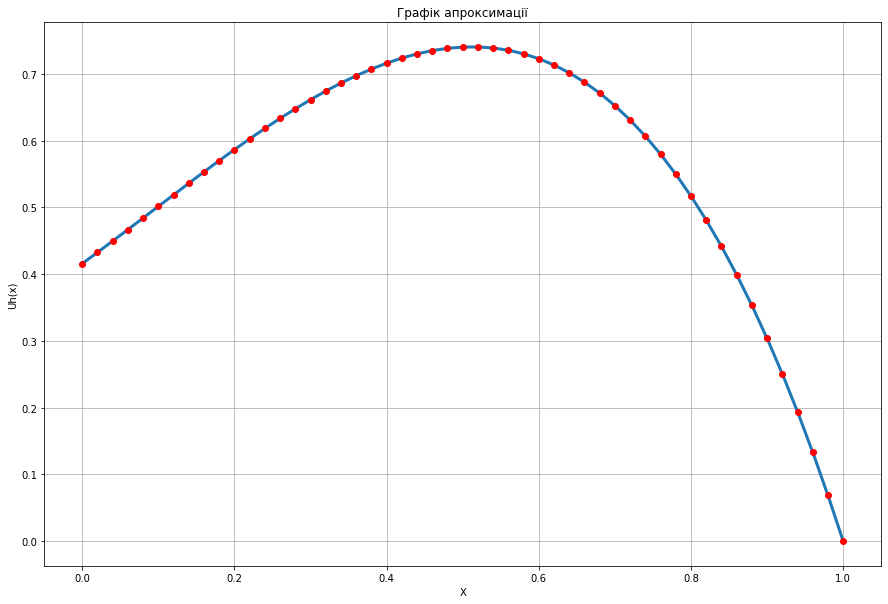

q0 = 0.415456477474316
q1 = 0.42381784950400025
q2 = 0.4322443562510983
q3 = 0.4407344999986999
q4 = 0.4492804243713843
q5 = 0.45787353572288475
q6 = 0.4665050083896592
q7 = 0.47516590037418904
q8 = 0.48384719156142486
q9 = 0.49253979926227304
q10 = 0.5012345854416469
q11 = 0.5099223603980413
q12 = 0.5185938847529484
q13 = 0.5272398705647897
q14 = 0.5358509819582159
q15 = 0.5444178354702259
q16 = 0.552931000223195
q17 = 0.5613809979879743
q18 = 0.5697583031748329
q19 = 0.5780533427756385
q20 = 0.5862564962722233
q21 = 0.5943580955207448
q22 = 0.6023484246186335
q23 = 0.6102177197586537
q24 = 0.6179561690732442
q25 = 0.6255539124713922
q26 = 0.6330010414696688
q27 = 0.6402875990186231
q28 = 0.6474035793254177
q29 = 0.6543389276733766
q30 = 0.661083540238948
q31 = 0.6676272639064718
q32 = 0.6739598960810527
q33 = 0.6800711844997723
q34 = 0.6859508270414276
q35 = 0.691588471534938
q36 = 0.6969737155665413
q37 = 0.7020961062858707
q38 = 0.7069451402109883
q39 = 0.7115102630324369
q40 = 0.7

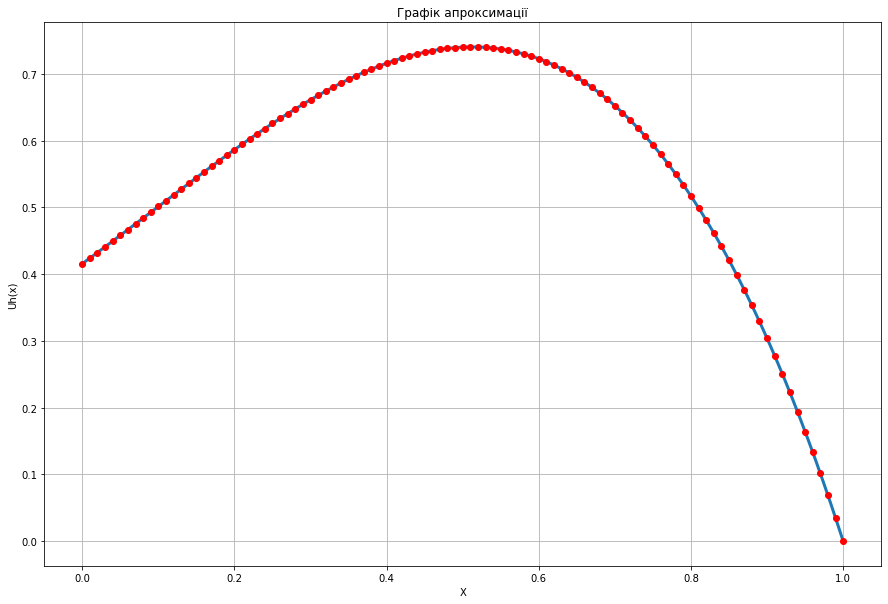

q0 = 0.4154084991467038
q1 = 0.41707232357586277
q2 = 0.4187390325304626
q3 = 0.42040885078441753
q4 = 0.4220817499535514
q5 = 0.42375767353311933
q6 = 0.42543655731051067
q7 = 0.42711833406951816
q8 = 0.4288029351565463
q9 = 0.43049029112477305
q10 = 0.4321803320389195
q11 = 0.4338729876346975
q12 = 0.43556818740881315
q13 = 0.43726586067288997
q14 = 0.43896593658736555
q15 = 0.44066834418365697
q16 = 0.44237301237914267
q17 = 0.4440798699875765
q18 = 0.44578884572650196
q19 = 0.4474998682226429
q20 = 0.4492128660158925
q21 = 0.4509277675623119
q22 = 0.4526445012364175
q23 = 0.4543629953329434
q24 = 0.4560831780682168
q25 = 0.45780497758123934
q26 = 0.45952832193454407
q27 = 0.46125313911487975
q28 = 0.46297935703375914
q29 = 0.46470690352790084
q30 = 0.46643570635958587
q31 = 0.46816569321694645
q32 = 0.4698967917141992
q33 = 0.4716289293918331
q34 = 0.4733620337167616
q35 = 0.4750960320824428
q36 = 0.4768308518089752
q37 = 0.4785664201431729
q38 = 0.4803026642586211
q39 = 0.48203951

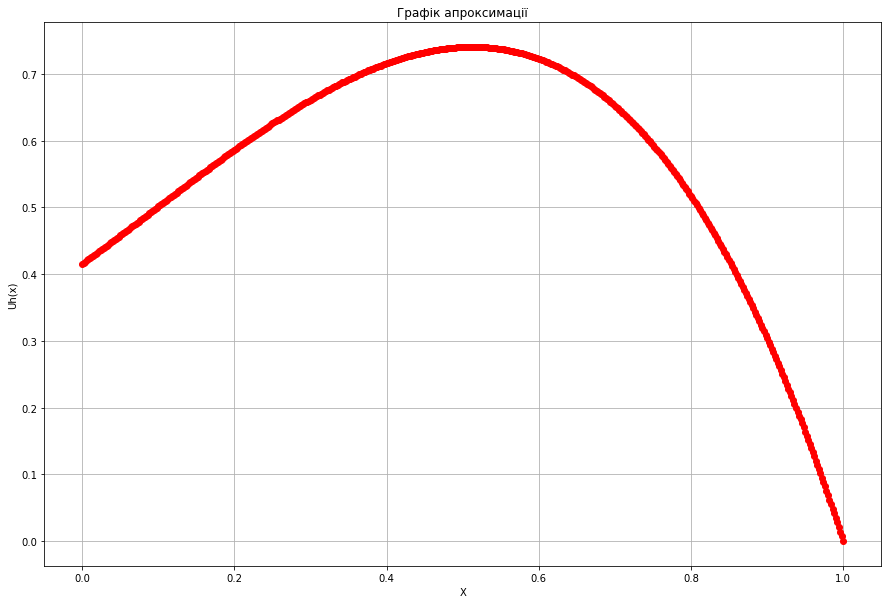

In [35]:
wide = False # Якщо Ви бажаєте вивести проміжні результати, змініть маячок wide=True
table = build_table(ni, wide) 

In [36]:
print(table)

if u != None:
    plot_function(u, a0, a1, "Графік функції U", 'X', 'U(x)')

     n  zero_norma  first_norma
0    3    0.617043     1.484660
1    5    0.599978     1.489095
2   10    0.593063     1.490880
3   30    0.591048     1.491206
4   50    0.590887     1.491208
5  100    0.590819     1.491203
6  500    0.590798     1.491198
